In [1]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import numpy as np
import random
import os

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

import pygame
from time import sleep
import Functions_and_classes
from Functions_and_classes import Star
from Functions_and_classes import star_position
from Functions_and_classes import Snake_tail, Snake, Snake_head
from Functions_and_classes import blit
pygame.quit()

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


Buliding an Enviroment

In [2]:
#Settting constatnts

WIDTH = HEIGHT = 900
WINDOW = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Snake")
BACKGROUND = (186, 255, 255)
FPS = WIDTH/20
CLOCK = pygame.time.Clock()

SNAKE_HEAD_IMG = pygame.image.load(os.path.join('Assets', 'Snake_head.png'))
SNAKE_TAIL_IMG = pygame.image.load(os.path.join('Assets', 'Snake_tail.png'))
SNAKE_HEAD = SNAKE_HEAD_IMG
STAR_IMG = pygame.image.load(os.path.join('Assets', 'Star.png'))

SPEED = 15

pygame.font.init() 
normal_size = pygame.font.SysFont('Comic Sans MS', round(WIDTH/30))
huge_size = pygame.font.SysFont('Comic Sans MS', round(HEIGHT/18))

WINDOW.fill(BACKGROUND)
label = huge_size.render("Welcome to Snake in Python!", 12, (0,0,0))
blit(label, (WIDTH/2)-(WIDTH/4), (HEIGHT/2)-(HEIGHT/9))

pygame.display.update()



In [7]:
def Make_board(star_list, head, tail_list):
    Table = np.zeros(shape=(int(WIDTH), int(HEIGHT)))
    
    #Creating a board imagine
    for star in star_list: #Setting stars
        Table[int(star.Rectangle.x), int(star.Rectangle.y)] = 3 
    
    Table[int(head.Rectangle.x), int(head.Rectangle.x)] = 1 #Creating Head
    print([(head.Rectangle.x), (head.Rectangle.x)])
    
    for tail in tail_list:
        Table[int(tail.Rectangle.x), int(tail.Rectangle.x)] = 2 #Creating tail
        print((tail.Rectangle.x), (tail.Rectangle.x))
    
    return Table.astype(int)
    

[450, 450]
450 450
450 450


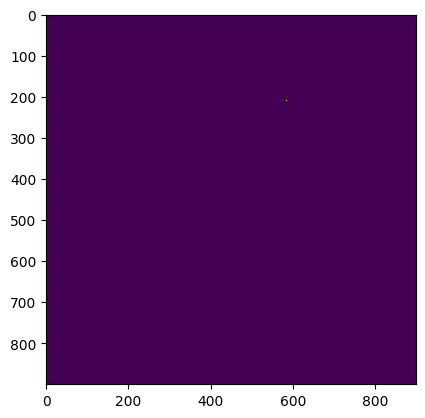

In [8]:
Hero = Snake()

board = Make_board(star_list=[Star(star_position(WIDTH), star_position(HEIGHT))], head=Hero, tail_list=Hero.list_of_tails)
from matplotlib import pyplot as plt
plt.imshow(np.array(board), interpolation='nearest')
plt.show()

pygame.quit()

In [20]:
class SnakeEnv(Env):
    def __init__(self):
        #Things for stable_baselines3
        self.action_space = Discrete(4) # --> 0 - free space, 1 - Head, 2 - Tail, 3 - Star
        self.observation_space = Box(low=0, high=5, shape=(WIDTH, HEIGHT), dtype=int)
        self.Hero = Snake()
        self.last_score = self.Hero.score  #Setting init score
        
        #Creating a star list
        star_list = [Star(star_position(WIDTH), star_position(HEIGHT))]
        
        for i in range(int(WIDTH/30)):
            star_list.append(Star(star_position(WIDTH), star_position(HEIGHT)))
        
        self.star_list = star_list

        #star_list_np = np.array([star_list.Rectangle.x, star_list.Rectangle.y], dtype=int) / 30 #Creating a np.array of position of stars in game space

        self.state = Make_board(star_list=self.star_list, head=self.Hero, tail_list=self.Hero.list_of_tails)

        self.learing_time = 200
        pass
    
    def step(self, action):
        # INIT A NEXT STEP
        
        global FPS 
        local_FPS = self.Hero.score + FPS
        CLOCK.tick(local_FPS) 
        WINDOW.fill(BACKGROUND)

        if (self.Hero.score > self.last_score) and (len(self.star_list) != WIDTH/60):
            self.star_list.pop(-1)
            self.last_score = self.Hero.score

        # Score sign
        label = normal_size.render("Score: {0}".format(self.Hero.score), 12, (0,0,0))
        self.WINDOW.blit(label, (0, 0))
        for i in self.star_list:
            i.draw()
        
        reward = self.Hero.score
        # MAKING ACTIONS
        
        #Difrent action changing state
        # Left = 0, Up = 1, Right = 2, Down =3
        if action == 0:
            self.Hero.rotate(90)
        if action == 2:
            self.Hero.rotate(270)
        if action == 3:
            self.Hero.rotate(180)
        if action == 1:
            self.Hero.rotate(0)  


        self.Hero.move() #Moving and colecting stars
        for i in self.star_list:
            self.Hero.collect_star(i)

        # ENDING A STEP PROCESS
        self.state = Make_board(star_list=self.star_list, head=self.Hero, tail_list=self.Hero.list_of_tails)

        info = {}

        if self.learing_time <= 0:
            done = True
        else:
            self.learing_time -= 1
            done = False

        pygame.display.update() #Update at very end!

        WINDOW.fill(BACKGROUND)    

        return self.observation_space, reward, done, info
    
    def render(self):
        pass
    
    def reset(self):
        self.Hero = Snake()
        self.last_score = self.Hero.score  #Setting init score
        
        #Creating a star list
        star_list = [Star(star_position(WIDTH), star_position(HEIGHT))]
        
        for i in range(int(WIDTH/30)):
            star_list.append(Star(star_position(WIDTH), star_position(HEIGHT)))
        
        self.star_list = star_list

        #star_list_np = np.array(star_list, dtype=int) / 30 #Creating a np.array of position of stars in game space

        self.state = Make_board(star_list=self.star_list, head=self.Hero, tail_list=self.Hero.list_of_tails)

        self.learing_time = 200
        pass

    def close(self):
        pygame.quit()
        pass

In [21]:
env = SnakeEnv()

In [22]:
log_path = os.path.join('Training', 'Logs')
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [23]:
model.learn(total_timesteps=100)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [16]:
env.close()

NameError: name 'env' is not defined